# Predicting Student Admissions with Neural Networks in Keras
In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:
- GRE Scores (Test)
- GPA Scores (Grades)
- Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

## Loading the data
To load the data and format it nicely, we will use two very useful packages called Pandas and Numpy. You can read on the documentation here:
- https://pandas.pydata.org/pandas-docs/stable/
- https://docs.scipy.org/

In [123]:
%qtconsole

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.utils import np_utils


In [125]:
# Reading the csv file into a pandas DataFrame
data = pd.read_csv('data/student_data.csv')

# Printing out the first 10 rows of our data
data[:10]

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
5,1,760,3.00,2
6,1,560,2.98,1
7,0,400,3.08,2
8,1,540,3.39,3
9,0,700,3.92,2


## Plotting the data

First let's make a plot of our data to see how it looks.

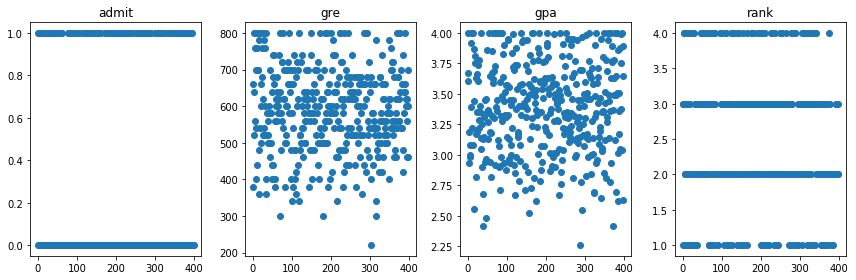

In [126]:
plt.figure(figsize=(12,4))
for ii, col in enumerate(data.columns):
    plt.subplot(1, len(data.columns), ii+1)
    plt.plot(data[col], 'o')
    plt.title(col)
plt.tight_layout()
plt.show()

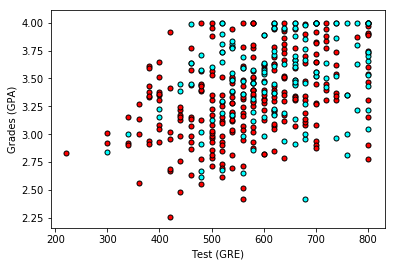

In [127]:
# Function to help us plot
# GPA v.s. GRE (In order to have a 2D plot, let's ingore the rank.)
def plot_points(data):
    X = np.array(data[["gre","gpa"]])
    y = np.array(data["admit"])
    admitted = (y==1)
    rejected = (y==0)
    plt.scatter(X[rejected, 0], X[rejected, 1], s=25, color='red', edgecolor='k')
    plt.scatter(X[admitted, 0], X[admitted, 1], s=25, color='cyan', edgecolor='k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
# Plotting the points
plot_points(data)
plt.show()

Roughly, it looks like the students with high scores in the grades and test passed, while the ones with low scores didn't, but the data is not as nicely separable as we hoped it would. Maybe it would help to take the rank into account? Let's make 4 plots, each one for each rank.

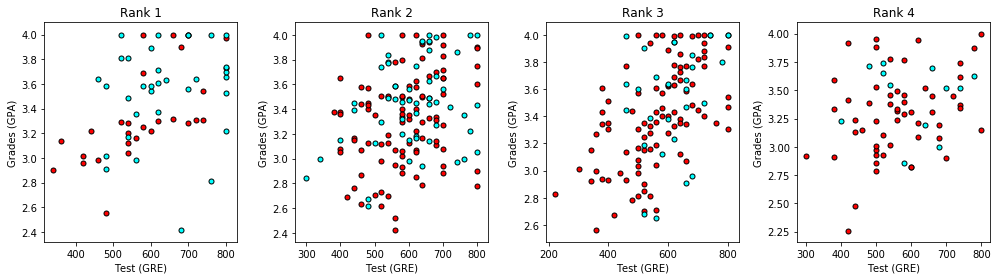

In [128]:
# plot GPA v.s. GRE for each rank
rank_vals = np.unique(data['rank'])
plt.figure(figsize=(14, 4))
for ii, rr in enumerate(rank_vals):
    data_rank_rr = data[data['rank']==rr]
    plt.subplot(1, len(rank_vals), ii+1)
    plt.title("Rank {}".format(rr))
    plot_points(data_rank_rr)
plt.tight_layout()
plt.show()
    

This looks more promising, as it seems that the lower the rank, the higher the acceptance rate. Let's use the rank as one of our inputs. In order to do this, we should one-hot encode it.

## One-hot encoding the rank
For this, we'll use the `get_dummies` function in pandas.

In [129]:
# Make dummy variables for rank
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)

# Drop the original rank column
one_hot_data = one_hot_data.drop('rank', axis=1)

# Print the first 10 rows of our data
one_hot_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1
5,1,760,3.00,0,1,0,0
6,1,560,2.98,1,0,0,0
7,0,400,3.08,0,1,0,0
8,1,540,3.39,0,0,1,0
9,0,700,3.92,0,1,0,0


## Scaling the data
The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to handle. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [130]:
# Copying our data
processed_data = one_hot_data.copy()

# Scaling the columns
processed_data['gre'] = processed_data['gre']/800
processed_data['gpa'] = processed_data['gpa']/4.0
processed_data[:10]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0
3,1,0.800,0.7975,0,0,0,1
4,0,0.650,0.7325,0,0,0,1
5,1,0.950,0.7500,0,1,0,0
6,1,0.700,0.7450,1,0,0,0
7,0,0.500,0.7700,0,1,0,0
8,1,0.675,0.8475,0,0,1,0
9,0,0.875,0.9800,0,1,0,0


## Splitting the data into features and targets (labels)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

Also, in Keras, we need to one-hot encode the output. We'll do this with the `to_categorical function`.
## Splitting the data into Training and Testing
In order to test our algorithm, we'll split the data into a Training and a Testing set. The size of the testing set will be 10% of the total data.

In [131]:
# Separate data and one-hot encode the output
# Note: We're also turning the data into numpy arrays, in order to train the model in Keras
X = np.array(processed_data.drop(['admit'], axis=1))
y = np.array(processed_data['admit'])
y = np_utils.to_categorical(y, 2)

# Split data into training and testing 
features, features_test, targets, targets_test = train_test_split(X, y, test_size=0.1, random_state=0)
print("Number of training samples is {}".format(features.shape[0]))
print("Number of testing samples is {}".format(features_test.shape[0]))
print(features[:10])
print(targets[:10])

Number of training samples is 360
Number of testing samples is 40
[[0.425  0.7875 0.     0.     1.     0.    ]
 [0.625  0.7525 0.     0.     0.     1.    ]
 [0.7    0.745  1.     0.     0.     0.    ]
 [0.825  0.9175 0.     0.     1.     0.    ]
 [0.575  0.7675 0.     1.     0.     0.    ]
 [0.825  0.835  0.     0.     1.     0.    ]
 [0.7    0.945  0.     1.     0.     0.    ]
 [0.8    0.8375 0.     0.     1.     0.    ]
 [0.825  0.8725 0.     1.     0.     0.    ]
 [0.525  0.6675 0.     0.     1.     0.    ]]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [132]:
# sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
# train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

# Separate data and one-hot encode the output
# Note: We're also turning the data into numpy arrays, in order to train the model in Keras
# features = np.array(train_data.drop('admit', axis=1))
# targets = np.array(np_utils.to_categorical(train_data['admit'], 2))
# features_test = np.array(test_data.drop('admit', axis=1))
# targets_test = np.array(np_utils.to_categorical(test_data['admit'], 2))

## Defining the model architecture
Here's where we use Keras to build our neural network.

In [201]:
# Build the model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=features.shape[1]))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(targets.shape[1], activation='sigmoid')) # last layer uses sigmoid, to output probability

# Compiling the model
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.6, nesterov=True)
# adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 128)               896       
_________________________________________________________________
dropout_67 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_104 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_68 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_105 (Dense)            (None, 2)                 130       
Total params: 9,282
Trainable params: 9,282
Non-trainable params: 0
_________________________________________________________________


## Training the model and scoring the model

In [202]:
# Training the model
model.fit(features, targets, epochs=200, batch_size=100, verbose=0)
# model.fit(features, targets, epochs=1000, batch_size=100, verbose=0)

# Evaluating the model on the training and testing set
score = model.evaluate(features, targets)
print("\n Training Accuracy:", score[1])
score = model.evaluate(features_test, targets_test)
print("\n Testing Accuracy:", score[1])

360/360 [==============================] - 0s 1ms/step

 Training Accuracy: 0.6861111111111111
40/40 [==============================] - 0s 128us/step

 Testing Accuracy: 0.65


## Challenge: Play with the parameters!
You can see that we made several decisions in our training. For instance, the number of layers, the sizes of the layers, the number of epochs, etc.
It's your turn to play with parameters! Can you improve the accuracy? The following are other suggestions for these parameters. We'll learn the definitions later in the class:
- Activation function: relu and sigmoid
- Loss function: categorical_crossentropy, mean_squared_error
- Optimizer: rmsprop, adam, ada